## Prepare Data for Modeling

**Wrangle**

1. Acquired data from student-mat.csv. 

2. Create dummy vars

3. Split data 

4. Scale data

wrangle.wrangle_sutdent_math(path) returns the following: 

| Object Returned | Description | Purpose                          |
|:-------------------|:--------------------------------|:----------------------------------------------------|
| 1. df | **Dataframe**, **Feature** and **target** variables, **Unscaled**, Dummy vars **with** original categorical vars | New features, additional cleaning needed, etc. |
| 2. X_train_exp | **Dataframe**, **Feature** variables only, **Unscaled**, Dummy vars **with** original categorical vars | Exploration & analysis     |
| 3. X_train | **Dataframe**, **Feature** variables only, **Scaled**, Dummy vars **without** original categorical vars | Feature selection, fit models, make predictions |
| 4. y_train | **Series**, **Target** variable only, **Unscaled** | Feature selection, evaluate model predictions |
| 5. X_validate | **Dataframe**, **Features** variables only, **Scaled**, Dummy vars **without** original categorical vars | Make predictions using top models |
| 6. y_validate | **Series**, **Target** variable only, **Unscaled** | Evaluate model predictions made from X_validate to assess overfitting | 
| 7. X_test | **Dataframe**, **Features** variables only, **Scaled**, Dummy vars **without** original categorical vars | Make predictions using best model|
| 8. y_test | **Series**, **Target** variable only, **Unscaled** | Evaluate model predictions made from X_test to estimate future performance on new data |

In [1]:
import pandas as pd
import numpy as np
import wrangle
import matplotlib.pyplot as plt

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

In [2]:
df, \
X_train_exp, \
X_train, \
y_train, \
X_validate, \
y_validate, \
X_test, \
y_test = wrangle.wrangle_student_math()

In [3]:
# check the head of our X:
X_train.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
142,0.000000,1.00,1.00,0.000000,0.666667,0.000000,0.75,0.25,0.25,0.00,0.00,1.00,0.035714,0.357143,0.578947
326,0.333333,0.75,0.75,0.000000,0.000000,0.000000,0.75,0.50,1.00,0.50,1.00,1.00,0.053571,0.714286,0.789474
88,0.166667,0.50,0.50,0.333333,0.333333,0.333333,0.75,0.75,0.25,0.00,0.00,0.50,0.214286,0.500000,0.526316
118,0.333333,0.25,0.75,0.666667,0.333333,0.333333,1.00,0.25,0.75,0.00,0.75,1.00,0.357143,0.357143,0.368421
312,0.666667,0.25,0.50,0.000000,0.333333,0.333333,0.75,1.00,0.25,0.25,0.25,0.75,0.053571,0.642857,0.578947


**Target Variable/y**

This helps us determine which type of algorithm we may want to use. 

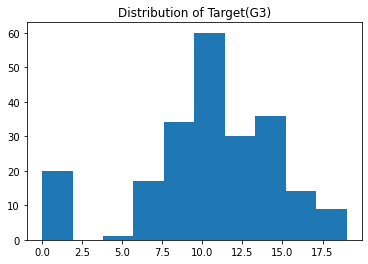

In [4]:
# how do we determine distribution?
plt.hist(y_train)
plt.title('Distribution of Target(G3)')
plt.show()

## Modeling

### Baseline

About the initial baseline: 

> Before we begin making models, we need to know how well we can estimate (predict) the final grade (G3) without using any features. This is often done by predicting every observation's target value to be the mean or the median. E.g. we could predict every student's final grade to be the mean final grade of all the students in our training sample. We will try both the mean and the median, see which performs best, and set that evaluation metric value as our baseline performance to beat. 


1. Predict all final grades to be 10.52, which is equal to the mean of G3 for the training sample. Store in `y_train['G3_pred_mean']`. 

2. Predict all final grades to be 11, which is equal to the median of G3 for the training sample. Store in `y_train['G3_pred_median']`.  

3. Compute the RMSE comparing actual final grade (G3) to G3_pred_mean. 

4. Compute the RMSE comparing actual final grade (G3) to G3_pred_median. 

In [5]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [6]:
# 1. Predict G3_pred_mean
G3_pred_mean = y_train.G3.mean()
y_train['G3_pred_mean'] = G3_pred_mean
y_validate['G3_pred_mean'] = G3_pred_mean

In [7]:
# 2. compute G3_pred_median
G3_pred_median = y_train.G3.median()
y_train['G3_pred_median'] = G3_pred_median
y_validate['G3_pred_median'] = G3_pred_median

In [8]:
# 3. RMSE of G3_pred_mean
rmse_train = mean_squared_error(y_train.G3,
                                y_train.G3_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_mean) ** (1/2)

In [9]:
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  4.5 
Validate/Out-of-Sample:  4.58


In [10]:
# 4. RMSE of G3_pred_median
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  4.52 
Validate/Out-of-Sample:  4.69



#### Addendum/Note:
we will incrementally build 
a dataframe for comparison of 
our metrics for model selection
for ease of reflection


In [11]:
from sklearn.metrics import explained_variance_score

In [12]:
def make_metric_df(y, y_pred, model_name, metric_df):
    if metric_df.size ==0:
        metric_df = pd.DataFrame(data=[
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }])
        return metric_df
    else:
        return metric_df.append(
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }, ignore_index=True)

In [13]:
# create the metric_df as a blank dataframe
metric_df = pd.DataFrame()
# make our first entry into the metric_df with median baseline
metric_df = make_metric_df(y_train.G3,
                           y_train.G3_pred_median,
                           'median_baseline',
                          metric_df)

In [14]:
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,4.523943,0.0


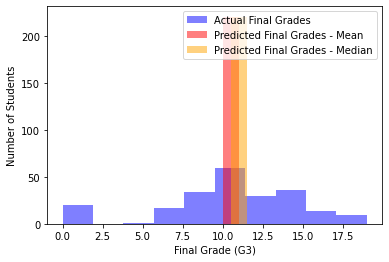

In [15]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.G3, color='blue', alpha=.5, label="Actual Final Grades")
plt.hist(y_train.G3_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Final Grades - Mean")
plt.hist(y_train.G3_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted Final Grades - Median")
plt.xlabel("Final Grade (G3)")
plt.ylabel("Number of Students")
plt.legend()
plt.show()

### LinearRegression (OLS)

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict final grade for students in training sample using our model (lm). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [16]:
y_train.head()

,G3,G3_pred_mean,G3_pred_median
142,11,10.524887,11.0
326,16,10.524887,11.0
88,10,10.524887,11.0
118,8,10.524887,11.0
312,11,10.524887,11.0


In [17]:
# create the model object
# 
# make the thing
# 
lm = LinearRegression(normalize=True)

In [18]:
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit the thing
# 
lm.fit(X_train, y_train.G3)

LinearRegression(normalize=True)

In [19]:
# predict train
# 
# use the thing!
# 
y_train['G3_pred_lm'] = lm.predict(X_train)

In [20]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_lm) ** (1/2)

# predict validate
y_validate['G3_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  1.750354650012114 
Validation/Out-of-Sample:  2.1264081323553423


In [21]:
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.G3, y_validate.G3_pred_lm)}, ignore_index=True)

In [22]:
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,4.523943,0.000000
1,OLS Regressor,2.126408,0.776807


### LassoLars

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict final grade for students in training sample using our model (lars). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [23]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.G3)

# predict train
y_train['G3_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_lars) ** (1/2)

# predict validate
y_validate['G3_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  4.498925523895268 
Validation/Out-of-Sample:  4.578916932633144


In [24]:
metric_df = make_metric_df(y_validate.G3,
               y_validate.G3_pred_lars,
               'lasso_alpha_1',
               metric_df)

In [25]:
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,4.523943,0.000000e+00
1,OLS Regressor,2.126408,7.768072e-01
2,lasso_alpha_1,4.578917,2.220446e-16


In [26]:
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,4.523943,0.000000e+00
1,OLS Regressor,2.126408,7.768072e-01
2,lasso_alpha_1,4.578917,2.220446e-16


<div style="border: 1px solid black; border-radius: 3px; background: green; padding: .5em 1em;">
    <p style="font-size: 1.3em; font-weight: bold">Mini Exercise</p>
    <ol>
        <li>Use a different <code>alpha</code> with the lasso model to try the fit with a different penalty based on the above code.</li>
        <li>What do you notice about the difference in rmse between train and validate sets?</li>
    </ol>
</div>

### TweedieRegressor (GLM)

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict final grade for students in training sample using our model (glm). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [27]:
from sklearn.linear_model import TweedieRegressor

In [28]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.G3)

# predict train
y_train['G3_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_glm) ** (1/2)

# predict validate
y_validate['G3_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  2.1831609449723266 
Validation/Out-of-Sample:  2.3833657201972533


<div style="border: 1px solid black; border-radius: 3px; background: green; padding: .5em 1em;">
    <p style="font-size: 1.3em; font-weight: bold">Mini Exercise</p>
    <ol>
        <li><code>Use a different power</code> with the generalized linear model to try the fit of a different distribution based on the above code.</li>
        <li>Does it seem to perform better or worse than the first pick? Could you see why it may change? What does "power" mean here?</li>
    </ol>
</div>

In [29]:
make_metric_df(y_validate.G3,
               y_validate.G3_pred_glm,
               'glm_poisson',
               metric_df)

,model,RMSE_validate,r^2_validate
0,median_baseline,4.523943,0.000000e+00
1,OLS Regressor,2.126408,7.768072e-01
2,lasso_alpha_1,4.578917,2.220446e-16
3,glm_poisson,2.383366,7.198167e-01


In [30]:
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,4.523943,0.000000e+00
1,OLS Regressor,2.126408,7.768072e-01
2,lasso_alpha_1,4.578917,2.220446e-16


### Polynomial Regression

Using sklearn.preprocessing.PolynommialFeatures() + sklearn.linear_model.LinearRegression()

1. Create the new features, based on value indicated for degree for train, validate & test. 

2. Fit the Linear Regression model

3. Predict using the transformed (squared or cubed, e.g.) features 

4. Evaluate using RMSE

5. Repeat predictions and evaluation for validation.

6. Compare RMSE train vs. validation. Overfitting?

## **PolynomialFeatures**

In [31]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 =  pf.transform(X_test)

## **LinearRegression**

In [32]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.G3)

# predict train
y_train['G3_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_lm2) ** (1/2)

# predict validate
y_validate['G3_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_lm2) ** 0.5

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  1.0440447820961478 
Validation/Out-of-Sample:  3.422342154558993


In [33]:
metric_df = make_metric_df(y_validate.G3,
               y_validate.G3_pred_lm2,
               'quadratic',
               metric_df)

In [34]:
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,4.523943,0.000000e+00
1,OLS Regressor,2.126408,7.768072e-01
2,lasso_alpha_1,4.578917,2.220446e-16
3,quadratic,3.422342,4.295427e-01


### Evaluate

**Plotting Actual vs. Predicted Values**

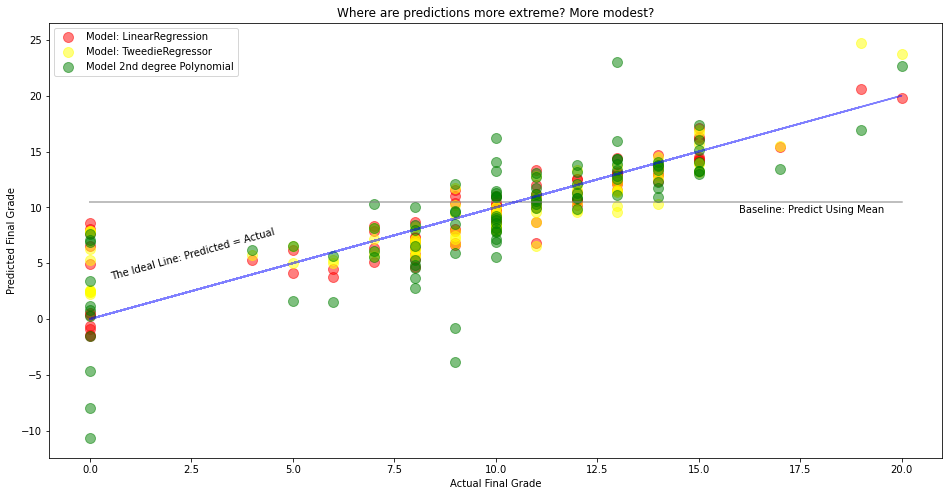

In [35]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.G3, y_validate.G3_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.G3, y_validate.G3, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.G3, y_validate.G3_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.G3, y_validate.G3_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.G3, y_validate.G3_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Grade")
plt.ylabel("Predicted Final Grade")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

**Residual Plots: Plotting the Errors in Predictions**

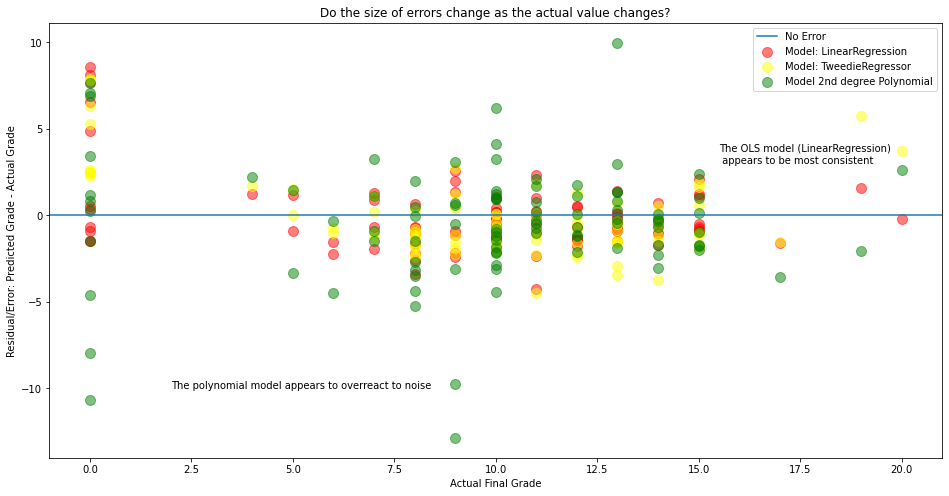

In [36]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.G3, y_validate.G3_pred_lm - y_validate.G3 , 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.G3, y_validate.G3_pred_glm - y_validate.G3, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.G3, y_validate.G3_pred_lm2 - y_validate.G3, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Grade")
plt.ylabel("Residual/Error: Predicted Grade - Actual Grade")
plt.title("Do the size of errors change as the actual value changes?")
plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

**Histograms**

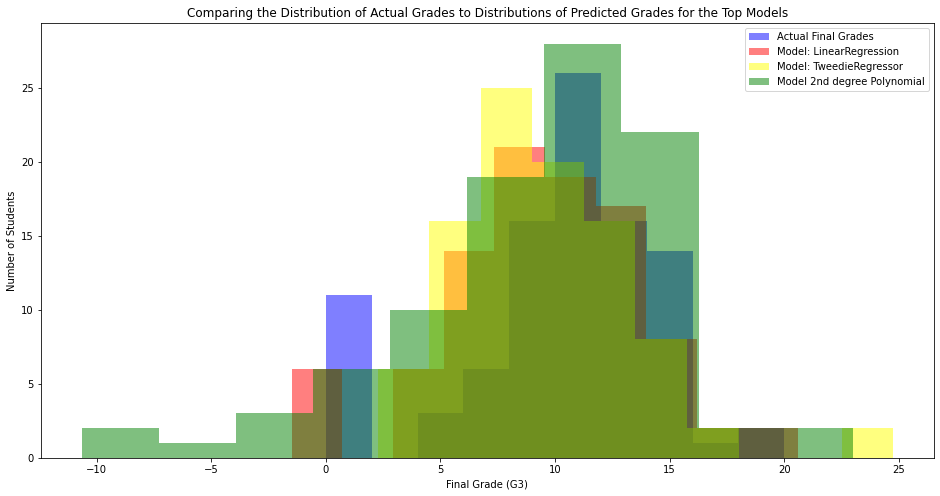

In [37]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.G3, color='blue', alpha=.5, label="Actual Final Grades")
plt.hist(y_validate.G3_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.G3_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.G3_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Final Grade (G3)")
plt.ylabel("Number of Students")
plt.title("Comparing the Distribution of Actual Grades to Distributions of Predicted Grades for the Top Models")
plt.legend()
plt.show()

In [38]:
# addendum: Comparing models DF:

In [39]:
metric_df

,model,RMSE_validate,r^2_validate
0,median_baseline,4.523943,0.000000e+00
1,OLS Regressor,2.126408,7.768072e-01
2,lasso_alpha_1,4.578917,2.220446e-16
3,quadratic,3.422342,4.295427e-01


**Model Selection & Out-of-Sample Evaluation**

Model selected: lm (using LinearRegression)

In [40]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['G3_pred_lm'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.G3, y_test.G3_pred_lm) ** (1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  1.9229879901741018
